<a href="https://colab.research.google.com/github/Vish4github/Projects/blob/master/Amazon_Cell_Phone_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Libraries

In [3]:
!pip install vaderSentiment
!pip install fastai
!pip install pyLDAvis

     |████████████████████████████████| 133kB 3.4MB/s 
     |████████████████████████████████| 1.6MB 3.3MB/s 
     |████████████████████████████████| 552kB 39.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=2130d63f4f64cab32ebbb222df4cb02982d95c667a085274bced10ff8e911387
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=02f6f4ec47b877681913466e98f60b61b751d9cdae47364cff326307d6965d34
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [4]:
from __future__ import print_function

import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf
tf.test.gpu_device_name()
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('movie_reviews')

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

# Sentiment Analysis
import textblob as tb
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from google.colab import files
from google.colab import drive as drive_colab
from google.colab import auth

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

## File Upload
Upload all the required files.  
**reviews.csv**: all available reviews  
**items.csv**: all phones available  

In [5]:
# Authenticate user
## You must go to the link and copy access code
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load all the required files
file_id = '17-i-_a2zKwXJCNoOCt6R-Ezr2swO8x8r'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('items.csv')

file_id = '1flTqx4fnPVrk5zyydJDvh67z4IIN-2Ei'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('reviews.csv')

# Mount the drive to access files
drive_colab.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
reviews = pd.read_csv('reviews.csv')
items = pd.read_csv('items.csv')

In [0]:
reviews.head(1)

,Unnamed: 0,index,body,brand,rating_x,sent_tb,tb_p,tb_n,tbnb_p,tbnb_n,sent_vader,vader_p,vader_n
0,0,0,I had the Samsung A600 for awhile which is abs...,NaN,3,0,0,0,0,0,0.8629,1,0


In [0]:
items.head(1)

,asin,brand,title,url,image,rating,reviewUrl,totalReviews,price,originalPrice
0,B0000SX2UC,NaN,Dual-Band / Tri-Mode Sprint PCS Phone w/ Voice...,https://www.amazon.com/Dual-Band-Tri-Mode-Acti...,https://m.media-amazon.com/images/I/2143EBQ210...,3.0,https://www.amazon.com/product-reviews/B0000SX2UC,14,0.0,0.0


# Exploratory Data Analysis

## Items Dataset
We have **720 phone models** and **10 features**.  
*rating*, *totalReviews*, *price* and *originalPrice* are **numerical**.  
All other features are **strings**.   

No significant NA's in this dataset.  

**Samsung** has the highest # of phones with 346, followed by **Motorola** having 105 and **Apple** has 63 phones.  

**Xiaomi** has the best rating of 4.4/5 followed by **HUAWEI** and then **ASUS**.

In [0]:
items.dtypes

asin              object
brand             object
title             object
url               object
image             object
rating           float64
reviewUrl         object
totalReviews       int64
price            float64
originalPrice    float64
dtype: object

In [0]:
items.shape

(720, 10)

In [0]:
items.isna().sum()

asin             0
brand            4
title            0
url              0
image            0
rating           0
reviewUrl        0
totalReviews     0
price            0
originalPrice    0
dtype: int64

In [0]:
item_brand = items.groupby('brand').agg({'asin':['count'], 'rating':['mean'], 'totalReviews':['sum']})
item_brand.columns = ['count_phone', 'avg_rating', 'total_reviews']
item_brand.sort_values(by="count_phone", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Samsung,346,3.632659,37701
Motorola,105,3.643810,9419
Apple,63,3.782540,6315
Xiaomi,46,4.415217,5574
Nokia,44,3.386364,6182
Google,38,3.771053,4238
HUAWEI,32,4.021875,2467
Sony,27,3.788889,3312
OnePlus,10,3.580000,406


In [0]:
item_brand.sort_values(by="avg_rating", ascending=False)

,count_phone,avg_rating,total_reviews
brand,,,
Xiaomi,46,4.415217,5574
HUAWEI,32,4.021875,2467
ASUS,5,3.860000,263
Sony,27,3.788889,3312
Apple,63,3.782540,6315
Google,38,3.771053,4238
Motorola,105,3.643810,9419
Samsung,346,3.632659,37701
OnePlus,10,3.580000,406


## Reviews Dataset
We have **67986 reviews** with **8 features**.  
*rating* and *helpfulVotes* are **numerical**.  
All other features are **strings**.

*helpfulVotes* has a lot of NA's.  
The other features have very few NA's.  

40% of the reviews are for **Samsung**.

In [0]:
reviews.dtypes

asin             object
name             object
rating            int64
date             object
verified           bool
title            object
body             object
helpfulVotes    float64
dtype: object

In [0]:
reviews.isna().sum()

asin                0
name                2
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64

In [0]:
reviews.shape

(67986, 8)

In [0]:
#reviews.head(2)
#reviews.loc[1,'body']
#tb.TextBlob(reviews.loc[1,'title'])
#tb.TextBlob("Text Messaging Doesn't Work", analyzer=NaiveBayesAnalyzer()).sentiment

## Merged Dataset

The dataset pulled atleast 80% of data available at that time per brand. **Samsung**, **Motorola** and **Nokia** have 90+% data.  

The highest deviation in ratings due to missing reviews is for OnePlus phones at 0.63. **Samsung**, **Motorola**, **Nokia** and **Apple** have less than 0.2 rating deviation.  

We see a bi-modal distribution of ratings for all the brands which is also representative of the plot with all brands combined.  



In [0]:
# Create a merged dataframe
df = pd.merge(reviews, items, on='asin')

# Find brand-wise summary
df_brand = df.groupby('brand').agg({'asin':['count'], 'rating_x':['mean']}).reset_index()
df_brand.columns = ['brand', 'reviews', 'avg_avlb_rating']
df_brand = df_brand.sort_values(by='reviews',ascending=False)
brand_summary = pd.merge(df_brand, item_brand, on='brand')
brand_summary['data_ratio'] = brand_summary['reviews']/brand_summary['total_reviews']
brand_summary['rating_dev'] = brand_summary['avg_avlb_rating'] - brand_summary['avg_rating']
brand_summary.to_csv("brand_summary.csv")
brand_summary

,brand,reviews,avg_avlb_rating,count_phone,avg_rating,total_reviews,data_ratio,rating_dev
0,Samsung,33629,3.781736,346,3.632659,37701,0.891992,0.149077
1,Motorola,8880,3.818694,105,3.643810,9419,0.942775,0.174884
2,Nokia,5915,3.584446,44,3.386364,6182,0.956810,0.198083
3,Apple,5145,3.701263,63,3.782540,6315,0.814727,-0.081276
4,Xiaomi,4411,4.371344,46,4.415217,5574,0.791353,-0.043873
5,Google,3787,3.584896,38,3.771053,4238,0.893582,-0.186157
6,Sony,3196,3.786921,27,3.788889,3312,0.964976,-0.001968
7,HUAWEI,2225,4.240899,32,4.021875,2467,0.901905,0.219024
8,OnePlus,347,4.213256,10,3.580000,406,0.854680,0.633256
9,ASUS,251,3.721116,5,3.860000,263,0.954373,-0.138884


In [0]:
brand_rating = pd.pivot_table(df, values='asin', index=['brand'], columns=['rating_x'], aggfunc='count')
brand_rating.to_csv("brand_rating.csv")
brand_rating

rating_x,1,2,3,4,5
brand,,,,,
ASUS,41,23,25,38,124
Apple,1191,243,322,545,2844
Google,883,286,267,435,1916
HUAWEI,246,63,124,268,1524
Motorola,1562,542,653,1310,4813
Nokia,1253,457,540,910,2755
OnePlus,46,6,13,45,237
Samsung,6646,1891,2292,4128,18672
Sony,511,259,280,496,1650


In [0]:
brand_rating = brand_rating.div(brand_rating.sum(axis=1), axis=0)
brand_rating

rating_x,1,2,3,4,5
brand,,,,,
ASUS,0.163347,0.091633,0.099602,0.151394,0.494024
Apple,0.231487,0.047230,0.062585,0.105928,0.552770
Google,0.233166,0.075522,0.070504,0.114867,0.505941
HUAWEI,0.110562,0.028315,0.055730,0.120449,0.684944
Motorola,0.175901,0.061036,0.073536,0.147523,0.542005
Nokia,0.211834,0.077261,0.091293,0.153846,0.465765
OnePlus,0.132565,0.017291,0.037464,0.129683,0.682997
Samsung,0.197627,0.056231,0.068155,0.122751,0.555235
Sony,0.159887,0.081039,0.087610,0.155194,0.516270


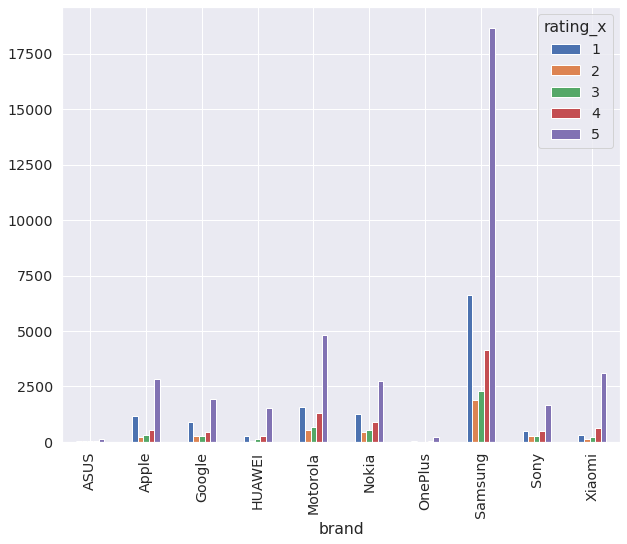

In [0]:
brand_rating.plot(kind='bar', figsize=(10,8))

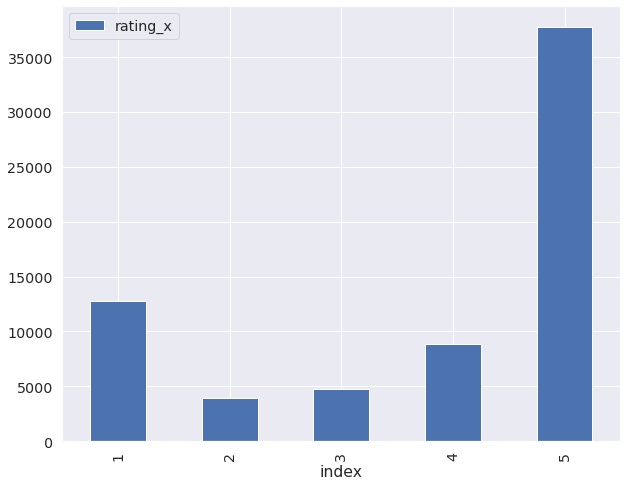

In [0]:
pd.DataFrame(df['rating_x'].value_counts()).reset_index().sort_values(by="index").plot(kind="bar", x="index", figsize=(10,8))

In [0]:
# Run this only when you want to overwrite
#!cp brand_rating.csv "drive/My Drive/Amazon_Reviews/"
#!cp brand_summary.csv "drive/My Drive/Amazon_Reviews/"

# Tokenization

In [0]:
df_reviews = df[['body', 'brand']].reset_index()
df_reviews['body'] = df_reviews['body'].fillna("")
df_reviews['word_count'] = 0
df_reviews['most_common'] = ""
df_reviews['common_count'] = 0
df_reviews['body_clean'] = ""
df_reviews.tail()

,index,body,brand,word_count,most_common,common_count,body_clean
67981,67981,I love the camera on this phone. The screen is...,Sony,0,,0,
67982,67982,I've been an Xperia user for several years and...,Sony,0,,0,
67983,67983,buy one more for my cousin,Sony,0,,0,
67984,67984,Product looks and works like new. Very much re...,Apple,0,,0,
67985,67985,I love the size and style of this phone. It is...,Samsung,0,,0,


In [0]:
stop_words = set(stopwords.words("english"))
for i in range(df_reviews.shape[0]):
    #Pick reviews one-by-one
    rev = df_reviews.iloc[i,1]
    
    # Make text lowercase, remove punctuation and remove words containing numbers
    rev = rev.lower()
    rev = rev.replace("."," .")
    rev = rev.replace("’"," ’")
    rev = re.sub('[%s]' % re.escape(string.punctuation), '', rev)
    rev = re.sub('\w*\d\w*', '', rev)

    # Tokenize the review
    tok_rev = word_tokenize(rev)
    
    #remove stop words
    filtered_rev = []
    for w in tok_rev:
        if w not in stop_words:
            filtered_rev.append(w)
    
    # store cleaned words
    df_reviews.iloc[i,6] = ' '.join(filtered_rev)

    #Compute number of words
    df_reviews.iloc[i,3] = len(filtered_rev)
    
    #Find the most common word and its count
    fdist = FreqDist(filtered_rev)
    
    if len(filtered_rev) > 1:
        df_reviews.iloc[i,4] = fdist.most_common(1)[0][0]
        df_reviews.iloc[i,5] = fdist.most_common(1)[0][1]
    else:
        df_reviews.iloc[i,4] = ""
        df_reviews.iloc[i,5] = 0

In [0]:
df_reviews.head()

,index,body,brand,word_count,most_common,common_count,body_clean
0,0,I had the Samsung A600 for awhile which is abs...,NaN,166,phone,7,samsung awhile absolute doo doo read review de...
1,1,Due to a software issue between Nokia and Spri...,NaN,68,sprint,3,due software issue nokia sprint phones text me...
2,2,"This is a great, reliable phone. I also purcha...",NaN,69,phone,3,great reliable phone also purchased phone sams...
3,3,"I love the phone and all, because I really did...",NaN,44,phone,5,love phone really need one didnt expect price ...
4,4,The phone has been great for every purpose it ...,NaN,57,get,5,phone great every purpose offers except day bo...


In [0]:
#df_reviews.to_csv("df_reviews.csv")
#!cp df_reviews.csv "drive/My Drive/Amazon_Reviews/"
df_reviews['word_count'].mean()

28.143558968022827

# Sentiment Analysis

def sentimental(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    return score

def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

def NaiveBaiyes_Sentimental(sentence):
    blob = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
    NaiveBayes_SentimentScore=blob.sentiment.classification
    return NaiveBayes_SentimentScore

In [0]:
#@title Data Source
pick_from_drive = True #@param {type:"boolean"}
if pick_from_drive:
  file_id = '1-hAZqHhS8pmiX3nJGV_WjQ_GG_cr9LRf'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('reviews.csv')
  df_reviews = pd.read_csv("df_reviews.csv")
### example usage ###
#tb.TextBlob("good is good", analyzer=NaiveBayesAnalyzer()).sentiment
#sent = "good bad"
#analyzer = SentimentIntensityAnalyzer()
#analyzer.polarity_scores(sent)['compound']

#df_sent.to_csv("df_sent_0.csv")
#!cp df_sent_0.csv "drive/My Drive/Amazon_Reviews/"

In [0]:
  file_id = '1-hAZqHhS8pmiX3nJGV_WjQ_GG_cr9LRf'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('df_sent_hybrid.csv')
  topic_df = pd.read_csv("df_sent_hybrid.csv")

In [0]:
# Create basic template of df for Sentiment Analysis
df_sent = df[['body', 'brand', 'rating_x']].reset_index()
df_sent['sent_tb'] = 0
df_sent['tb_p'] = 0
df_sent['tb_n'] = 0
df_sent['tbnb_p'] = 0
df_sent['tbnb_n'] = 0
df_sent['sent_vader'] = 0
df_sent['vader_p'] = 0
df_sent['vader_n'] = 0

In [0]:
#@title Simple TextBlob Analyzer
cutoff_sent =  0#@param {type:"number"}

for i in range(df_sent.shape[0]):
  #Pick a review
  rev = str(df_sent.iloc[i,1])

  # TextBlob Sentiment Analyzer
  df_sent.iloc[i,4] = tb.TextBlob(rev).sentiment.polarity

  # Pessimistic approach, neutral sentiment => bad review
  if df_sent.iloc[i,4] > cutoff_sent:
    df_sent.iloc[i,5] = 1
  else:
    df_sent.iloc[i,6] = 1

In [0]:
#@title TextBlob Analyzer: NaiveBayesAnalyzer
cutoff_sent = 0 #@param {type:"number"}

for i in range(df_sent.shape[0]):
  #Pick a review
  rev = str(df_sent.iloc[i,1])

  # TextBlob Sentiment Analyzer with Naive Bayes
  tb_sent_class = tb.TextBlob(rev, analyzer=NaiveBayesAnalyzer()).sentiment.classification

  # TextBlob with Naive Bayes Analyzer
  if tb_sent_class == "pos":
    df_sent.iloc[i,7] = 1
  else:
    df_sent.iloc[i,8] = 1

In [0]:
#@title VADER Analyzer
cutoff_sent =  0#@param {type:"number"}

for i in range(df_sent.shape[0]):
  # Pick a review
  rev = str(df_sent.iloc[i,1])

  # VADER Sentiment Analyzer
  analyzer = SentimentIntensityAnalyzer()
  vs = analyzer.polarity_scores(rev)
  score = vs['compound']
  df_sent.iloc[i,9] = score
  if df_sent.iloc[i,3] == 5:
    if score > 0.5:
      df_sent.iloc[i,10] = 1
    else:
      df_sent.iloc[i,11] = 1
  else:
    if score >= 0:
      df_sent.iloc[i,10] = 1
    else:
      df_sent.iloc[i,11] = 1

In [0]:
#pd.concat([df_reviews, df['rating_x']], axis=1)
df_sent.to_csv("df_sent_hybrid.csv")
!cp df_sent_hybrid.csv "drive/My Drive/Amazon_Reviews/"

In [0]:
review_sentiment = df_sent.groupby('brand').agg({'sent_tb':['mean'], 
                                                 'tb_p':['sum'],
                                                 'tb_n':['sum'],
                                                 'sent_vader':['mean'],
                                                 'vader_p':['sum'],
                                                 'vader_n':['sum']}).reset_index()
review_sentiment.columns = ['brand', 'avg_sent_tb', 'tb_p', 'tb_n', 'avg_sent_vader', 'vader_p', 'vader_n']
review_sentiment

,brand,avg_sent_tb,tb_p,tb_n,avg_sent_vader,vader_p,vader_n
0,ASUS,0,0,0,0.450343,177,74
1,Apple,0,0,0,0.303738,3124,2021
2,Google,0,0,0,0.371158,2549,1238
3,HUAWEI,0,0,0,0.456779,1499,726
4,Motorola,0,0,0,0.405286,6120,2760
5,Nokia,0,0,0,0.373347,4018,1897
6,OnePlus,0,0,0,0.488430,244,103
7,Samsung,0,0,0,0.361681,22199,11430
8,Sony,0,0,0,0.447593,2263,933
9,Xiaomi,0,0,0,0.396646,2592,1819


In [0]:
# Check False Positives (2417)
df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] < 3)]

,index,body,brand,rating_x,sent_tb,tb_p,tb_n,tbnb_p,tbnb_n,sent_vader,vader_p,vader_n
1,1,Due to a software issue between Nokia and Spri...,NaN,1,0.119792,1,0,0,0,0.8720,1,0
11,11,1.) Slow - If you want to check your missed ca...,NaN,1,-0.004879,0,1,0,0,0.5457,1,0
30,30,"I asked my friend to toss me my phone, but wha...",Motorola,1,0.072747,1,0,0,0,0.9866,1,0
44,44,I bought this phone and found out IDEN phones ...,Motorola,1,0.000000,0,1,0,0,0.1280,1,0
59,59,I find texting impossible on this phone. As an...,Motorola,1,-0.194444,0,1,0,0,0.4404,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
67837,67837,The phones were locked. I purchased 2 -one for...,Samsung,1,0.119388,1,0,0,0,0.7405,1,0
67907,67907,This phone isnt worth the price. While it has ...,OnePlus,1,0.218244,1,0,0,0,0.9802,1,0
67935,67935,The Smartphone seems to be OK but no signature...,Sony,1,-0.037500,0,1,0,0,0.4618,1,0
67955,67955,"say what you want, Sony makes the best Android...",Sony,2,0.131300,1,0,0,0,0.9614,1,0


In [0]:
# Check Rating = 3 and Positives (1569)
df_sent[(df_sent['vader_p'] == 1) & (df_sent['rating_x'] == 3)]

,index,body,brand,rating_x,sent_tb,tb_p,tb_n,tbnb_p,tbnb_n,sent_vader,vader_p,vader_n
0,0,I had the Samsung A600 for awhile which is abs...,NaN,3,0.119780,0,1,0,0,0.8629,1,0
3,3,"I love the phone and all, because I really did...",NaN,3,0.301563,0,1,0,0,0.9592,1,0
9,9,ok well im in school and i need the text messa...,NaN,3,0.248148,0,1,0,0,0.6486,1,0
76,76,"Short: This phone works fine as a basic phone,...",Nokia,3,0.048788,0,1,0,0,0.5346,1,0
80,80,"By simple I mean that in a good way, having co...",Samsung,3,0.160178,0,1,0,0,0.9864,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
67813,67813,I had the Moto E4 Plus for exactly two years a...,Motorola,3,0.102395,0,1,0,0,0.9118,1,0
67956,67956,Unboxing: The unboxing is straightforward; jus...,Sony,3,0.153354,0,1,0,0,0.9991,1,0
67960,67960,Final Update: I ended up ordering another Sams...,Sony,3,0.138322,0,1,0,0,0.9862,1,0
67963,67963,"I really wanted to like this phone, but it’s b...",Sony,3,0.139304,0,1,0,0,0.9249,1,0


In [0]:
# Check Rating = 3 and Negatives (3183)
df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] == 3)]

,index,body,brand,rating_x,sent_tb,tb_p,tb_n,tbnb_p,tbnb_n,sent_vader,vader_p,vader_n
25,25,I got this phone just as secondary cell phone....,Motorola,3,0.324000,0,1,0,0,0.2382,0,1
29,29,way too small,Motorola,3,-0.250000,0,1,0,0,0.0000,0,1
41,41,I got this phone based on a recommendation fro...,Motorola,3,0.014865,0,1,0,0,-0.4228,0,1
66,66,Purchased 2 and one worked....,Motorola,3,0.000000,0,1,0,0,0.0000,0,1
68,68,They are showing a cingular phone which is ide...,Motorola,3,0.500000,0,1,0,0,0.1154,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
67847,67847,Ruim,Samsung,3,0.000000,0,1,0,0,0.0000,0,1
67872,67872,It is a nice phone. The picture showed a SD ca...,Samsung,3,0.600000,1,0,0,0,0.4174,0,1
67879,67879,It's making to.much nois,Samsung,3,0.000000,0,1,0,0,0.0000,0,1
67965,67965,Beautiful concept for a phone but the FINGERPR...,Sony,3,0.193333,0,1,0,0,-0.8794,0,1


In [0]:
# Check False Negatives (15119)
df_sent[(df_sent['vader_n'] == 1) & (df_sent['rating_x'] > 3)]

,index,body,brand,rating_x,sent_tb,tb_p,tb_n,tbnb_p,tbnb_n,sent_vader,vader_p,vader_n
24,24,SERVED ME WELL AS A BACK UP PHONE.,Motorola,5,0.000000,0,1,0,0,0.2732,0,1
26,26,Sturdy - clarity is great - easy to use Only p...,Motorola,4,0.308333,0,1,0,0,0.4404,0,1
31,31,"We never use cell phones, but thought we neede...",Motorola,5,0.097708,0,1,0,0,-0.6526,0,1
36,36,this is a good little inexpensive phone - basi...,Motorola,4,0.170833,0,1,0,0,0.2344,0,1
37,37,"I almost never write reviews for anything, but...",Motorola,5,0.013631,0,1,0,0,-0.9063,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
67948,67948,"Sorry, this video is unsupported on this brows...",Sony,5,-0.061190,0,1,0,0,0.4372,0,1
67950,67950,En general es uno de los mejores Xperia que he...,Sony,5,0.050000,0,1,0,0,0.0000,0,1
67953,67953,Quility,Sony,5,0.000000,0,1,0,0,0.0000,0,1
67968,67968,forget about iPhones. I've been using xperia s...,Sony,5,0.318750,0,1,0,0,0.2398,0,1


In [0]:
df_sent.loc[67968,'body']

"forget about iPhones. I've been using xperia since ever, and I see it's getting more and more advanced. compare as you want to any other devices, from any aspects."

In [0]:
### GHOST ###

In [0]:
top_words = df_reviews.groupby('most_common').agg({'index':['count']})
top_words.columns = ["_".join(x) for x in top_words.columns.ravel()]
top_words = top_words.sort_values(by='index_count',ascending=False)

In [0]:
def plot_10_most_common_words(count_data, count_vectorizer):  
    words = count_vectorizer.get_feature_names()  
    total_counts = np.zeros(len(words))  
    for t in count_data:  
        total_counts+=t.toarray()[0] 
        count_dict = (zip(words, total_counts))  
        count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]  
        words = [w[0] for w in count_dict]  
        counts = [w[1] for w in count_dict]  
        x_pos = np.arange(len(words))   
     
    plt.figure(2, figsize=(15, 15/1.6180))  
    plt.subplot(title='10 most common words',axisbg='white')  
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})  
    sns.barplot(x_pos, counts, palette='husl')  
    plt.xticks(x_pos, words, rotation=90)   
    plt.xlabel('words')  
    plt.ylabel('counts')  
    plt.show()
count_vectorizer = CountVectorizer(stop_words='english')  
count_data = count_vectorizer.fit_transform(df_reviews['body'])
plot_10_most_common_words(count_data, count_vectorizer)

AttributeError: ignored

<Figure size 1080x667.491 with 0 Axes>

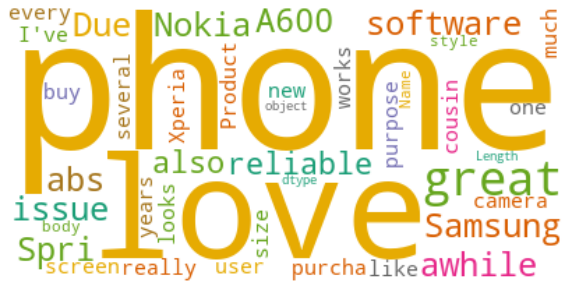

In [0]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
wc.generate(str(df_reviews.body))
plt.figure( figsize=(10,10) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modeling

In [6]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.05, stop_words="english")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Just importing, imputing and cleaning the data again. Not required but for testing purposes

In [0]:
items_df=items.copy()
reviews_df=reviews.copy()
items_df['brand'] = np.where((items_df.asin == 'B0000SX2UC'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B01EWKHIAI'),'Nokia',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07JHXX5YR'),'ASUS',items_df.brand)
items_df['brand'] = np.where((items_df.asin == 'B07T3KMJW8'),'Xiaomi',items_df.brand)
merged_data=pd.merge (items_df,reviews_df,how='left',on='asin')
merged_data.shape

KeyError: ignored

In [0]:
merged_data=merged_data.rename(columns={'rating_x': 'Average_Rating','rating_y':'Customer_Rating','title_x':'Product_Name','title_y':'Review_title'})

## Cleaning using NLTK

Need to clean the reviews - lower case,remove punctuations and keywords like brand name, phone and finally lemmatize

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer("english")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
#keywords = merged_data["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
lemma = WordNetLemmatizer()
def clean_text(text):
    # Convert the text into lowercase
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_key]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)
clean_text('This is our collaboratory notebook for Data Mining Project. Okay you should be excited reading this!')

'collaboratory notebook data mining project okay excited reading'

In [0]:
keywords

['nokia',
 'motorola',
 'samsung',
 'huawei',
 'sony',
 'apple',
 'google',
 'asus',
 'oneplus',
 'xiaomi',
 'phone']

In [0]:
merged_data["body"] = merged_data["body"].astype("str")
merged_data["clean_text"] = merged_data["body"].apply(clean_text)
merged_data["positivity"] = merged_data["Customer_Rating"].apply(lambda x: 1 if x>3 else(0 if x==3 else -1))

Creating an Apple only dataset

In [0]:
merged_data["clean_text"].head().values
apple = merged_data[merged_data["brand"]=="Apple"].sort_values(by=["date"], ascending=False)
apple["renewed"] = apple["Product_Name"].apply(lambda x: ("Renewed" in x) | ("Refurbished" in x))

In [0]:
apple[apple['renewed']==True]
#apple.shape

,asin,brand,Product_Name,url,image,Average_Rating,reviewUrl,totalReviews,price,originalPrice,name,Customer_Rating,date,verified,Review_title,body,helpfulVotes,clean_text,positivity,renewed
37805,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Zoriah Bradshaw,5,"September 9, 2019",True,Works fine,Works fine,NaN,work fine,1,True
42149,B07755LZ67,Apple,Apple iPhone 8 Plus 64GB Unlocked GSM Phone - ...,https://www.amazon.com/Apple-iPhone-Unlocked-G...,https://m.media-amazon.com/images/I/810MbmOEoq...,4.0,https://www.amazon.com/product-reviews/B07755LZ67,176,374.99,0.00,Timothy,5,"September 9, 2019",True,I like my new iPhone,It did not come with an AC charger,NaN,come ac charger,1,True
41893,B0775451TT,Apple,"Apple iPhone X, 256GB, Silver - For AT&T / T-M...",https://www.amazon.com/Apple-iPhone-Fully-Unlo...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B0775451TT,436,479.00,749.99,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True
35704,B071JPQYGK,Apple,"Apple iPhone 7 Plus, AT&T Locked, 128GB - Jet ...",https://www.amazon.com/Apple-iPhone-Plus-128GB...,https://m.media-amazon.com/images/I/61dI0syR1r...,3.5,https://www.amazon.com/product-reviews/B071JPQYGK,12,284.99,549.99,Amazon Customer,1,"September 9, 2019",True,This product was a scam,The phone was either stolen or tossed by the o...,NaN,stolen tossed owner att stated owner owes unlo...,-1,True
48696,B07D6TQP6F,Apple,"Apple iPhone X, 256GB, Silver - For AT&T (Rene...",https://www.amazon.com/Apple-iPhone-AT-256GB-R...,https://m.media-amazon.com/images/I/81yZOQEC+N...,3.9,https://www.amazon.com/product-reviews/B07D6TQP6F,436,476.00,0.00,Amazon Customer,5,"September 9, 2019",True,Awesome !,Phone works perfect! Looks brand new ! No scra...,NaN,work perfect look brand new scratch fresh store,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37581,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Greg,5,"April 1, 2019",True,Seems like a great buy,I bought this for my daughter and she seems ve...,NaN,bought daughter pleased use ting service super...,1,True
37616,B0731HBTZ7,Apple,"Apple iPhone 7 32GB, Rose Gold (Renewed)",https://www.amazon.com/Apple-iPhone-32GB-Rose-...,https://m.media-amazon.com/images/I/51cRE43zKw...,3.8,https://www.amazon.com/product-reviews/B0731HBTZ7,452,199.95,210.00,Michelle elder,4,"April 1, 2019",True,Gets hot easy.. Kinda worried and honna keep a...,Works with safelink wireless. Put in sim card ...,NaN,work safelink wireless sim card old worked im...,1,True
31785,B06XRJQX91,Apple,"Apple iPhone 6S, 64GB, Rose Gold - For AT&T / ...",https://www.amazon.com/Apple-iPhone-Unlocked-D...,https://m.media-amazon.com/images/I/61+mrwyL24...,3.6,https://www.amazon.com/product-reviews/B06XRJQX91,427,158.88,271.84,Insiya Hasan,3,"April 1, 2018",True,Three Stars,The phone did have scratches and a dent on it ...,2.0,scratch dent tends overheat,0,True
42977,B077XM1GZM,Apple,"Apple iPhone 6S Plus, 64GB, Silver - Fully Unl...",https://www.amazon.com/Apple-iPhone-a1687-Unlo...,https://m.media-amazon.com/images/I/81ia5dHUn3...,3.8,https://www.amazon.com/product-reviews/B077XM1GZM,12,258.80,349.99,Cheesey,5,"April 1, 2018",True,Quality,Quality refurbished phone. Looks and works lik...,5.0,quality refurbished look work like brand new f...,1,True


In [0]:
clean_text('No no thats not how you clean. Delete it')

'thats clean delete'

## Ngrams and Wordclouds


In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(apple["clean_text"], 10)
for word, freq in common_words:
    print(word, freq)



brand new 366
battery life 359
like new 318
sim card 214
work great 176
screen protector 150
perfect condition 117
look like 111
battery health 100
good condition 92


In [0]:
df4 = pd.DataFrame(common_words, columns = ['Bigrams' , 'count'])
df4.head()

,Bigrams,count
0,brand new,366
1,battery life,359
2,like new,318
3,sim card,214
4,work great,176


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

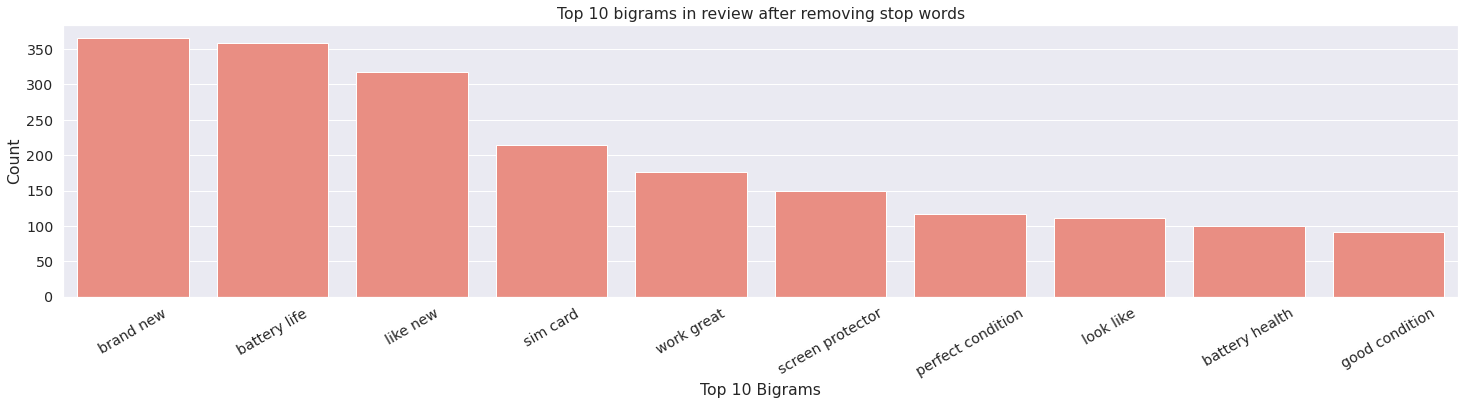

In [0]:
plt.figure(figsize=(25,5))
sns.barplot(x='Bigrams',y='count',data=df4,color="salmon")
plt.xlabel('Top 10 Bigrams')
plt.ylabel('Count')
plt.title('Top 10 bigrams in review after removing stop words')
plt.xticks(rotation=30);


In [0]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_trigrams = get_top_n_trigram(apple["clean_text"], 10)
for word, freq in common_words_trigrams:
    print(word, freq)

df5 = pd.DataFrame(common_words_trigrams, columns = ['Trigrams' , 'count'])
df5.head()

like brand new 84
look brand new 83
look like new 61
work like new 57
looked brand new 37
came screen protector 35
like new condition 26
brand new scratch 23
came perfect condition 23
glass screen protector 21


,Trigrams,count
0,like brand new,84
1,look brand new,83
2,look like new,61
3,work like new,57
4,looked brand new,37


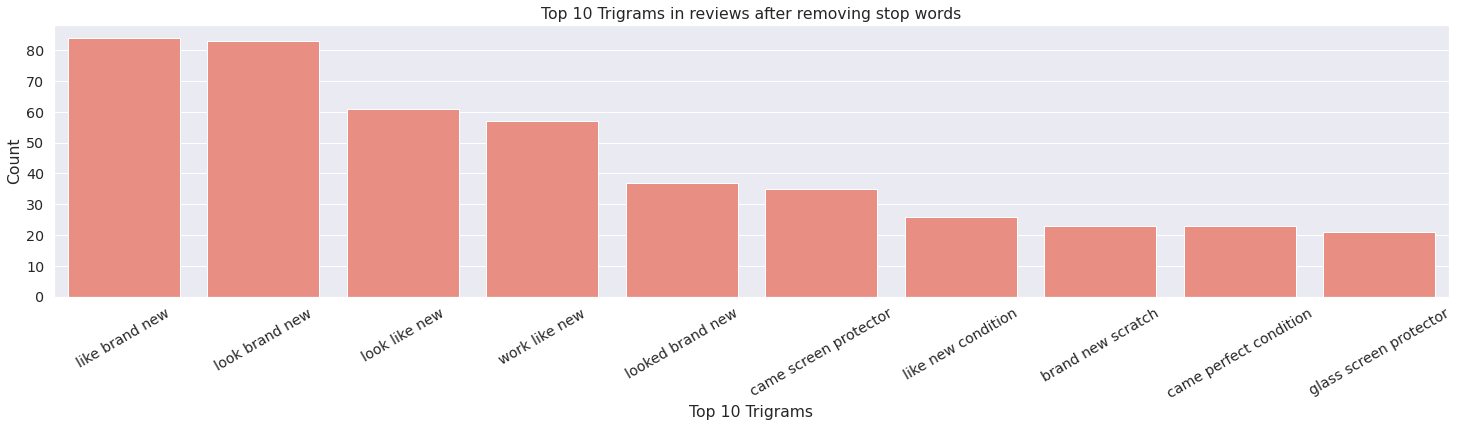

In [0]:
plt.figure(figsize=(25,5))
sns.barplot(x='Trigrams',y='count',data=df5,color="salmon")
plt.xlabel('Top 10 Trigrams')
plt.ylabel('Count')
plt.title('Top 10 Trigrams in reviews after removing stop words')
plt.xticks(rotation=30);

In [0]:
from wordcloud import WordCloud, ImageColorGenerator

# Define a function to create a wordcloud from dictionary of word frequency
def wordcloud_from_frequency(word_freq_dict, title, figure_size=(10, 6)):
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [0]:
def word_freq_dict(text):
    # Convert text into word list
    wordList = text.split()
    # Generate word freq dictionary
    wordFreqDict = {word: wordList.count(word) for word in wordList}
    return wordFreqDict

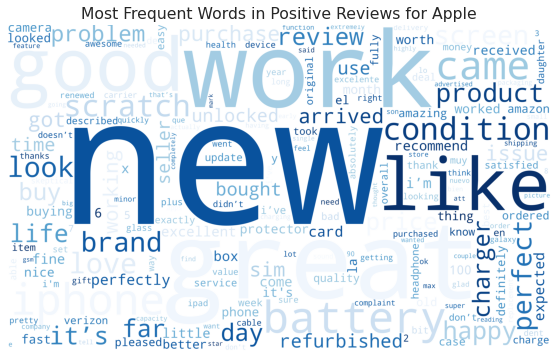

In [0]:
apple_pos = " ".join(apple[apple["positivity"]==1]["clean_text"])
apple_pos_word_freq = word_freq_dict(apple_pos)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="Blues",
                      background_color="white")
wordcloud_from_frequency(apple_pos_word_freq, "Most Frequent Words in Positive Reviews for Apple")

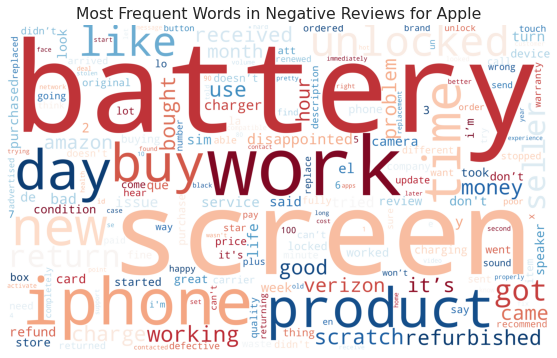

In [0]:
apple_neg = " ".join(apple[apple["positivity"]==-1]["clean_text"])
apple_neg_word_freq = word_freq_dict(apple_neg)
wordcloud = WordCloud(width=5000, 
                      height=3000, 
                      max_words=200, 
                      colormap="RdBu",
                      background_color="white")
wordcloud_from_frequency(apple_neg_word_freq, "Most Frequent Words in Negative Reviews for Apple")

##Getting the data for Topic Modelling

In [0]:
  file_id = '1-hAZqHhS8pmiX3nJGV_WjQ_GG_cr9LRf'
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile('df_sent_hybrid.csv')
  topic_df = pd.read_csv("df_sent_hybrid.csv")

In [0]:
topic_df['brand']=topic_df['brand'].astype(str)

In [11]:
keywords = topic_df["brand"].apply(lambda x: x.lower()).unique().tolist()
keywords.append("phone")
keywords.append("iphone")
lemma = WordNetLemmatizer()
def clean_text(text):
    # Convert the text into lowercase
    lower = text.lower()
    # Split into list
    wordList = lower.split()
    # Remove punctuation
    wordList_punc = ["".join(i for i in word if (i=="'")|(i not in string.punctuation)) for word in wordList]
    # Remove stopwords
    wordList_stop = [word for word in wordList_punc if word not in list(spacy_stopwords)]
    # Remove other keywords
    wordList_key = [word for word in wordList_stop if word not in keywords]
    # Stemming
    #words_stemmed= [stemmer.stem(word) for word in wordList_key]
    # Lemmatisation
    #lemma_word = nlp(wordList)
    wordList_clean = [lemma.lemmatize(word) for word in wordList_key]
    #wordList = [word.lemma_ for word in wordList]
    return " ".join(wordList_clean)
clean_text('This is our collaboratory notebook for Data Mining Project. Okay you should be excited reading this!')

'collaboratory notebook data mining project okay excited reading'

In [12]:
keywords

['nan',
 'motorola',
 'nokia',
 'samsung',
 'huawei',
 'sony',
 'apple',
 'google',
 'asus',
 'oneplus',
 'xiaomi',
 'phone',
 'iphone']

## LDA - Latent Dirichlet Allocation

In [0]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Data subsets for Apple, Samsung and Xiaomi

In [14]:
topic_df_Apple=topic_df[topic_df['brand']=='Apple']
topic_df_Apple['body']=topic_df_Apple['body'].astype(str)
topic_df_Apple_pos=topic_df_Apple[topic_df_Apple['vader_p']==1]
topic_df_Apple_neg=topic_df_Apple[topic_df_Apple['vader_n']==1]


topic_df_Samsung=topic_df[topic_df['brand']=='Samsung']
topic_df_Samsung['body']=topic_df_Samsung['body'].astype(str)
topic_df_Samsung_pos=topic_df_Samsung[topic_df_Samsung['vader_p']==1]
topic_df_Samsung_neg=topic_df_Samsung[topic_df_Samsung['vader_n']==1]



topic_df_Xiaomi=topic_df[topic_df['brand']=='Xiaomi']
topic_df_Xiaomi['body']=topic_df_Xiaomi['body'].astype(str)
topic_df_Xiaomi_pos=topic_df_Xiaomi[topic_df_Xiaomi['vader_p']==1]
topic_df_Xiaomi_neg=topic_df_Xiaomi[topic_df_Xiaomi['vader_n']==1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Creating the DTM using bigrams and trigrams

In [0]:
topic_df_Apple_neg["clean_text"] = topic_df_Apple_neg["body"].apply(clean_text)
cv = CountVectorizer(ngram_range=(2,3),stop_words='english')
dtm = cv.fit_transform(topic_df_Apple_neg['clean_text'])
#dtm = cv.fit_transform(topic_df["body"])
#common_words_bigrams = get_top_n_bigram(topic_df_Apple_neg['body'])
#bigrams_list = [a_tuple[0] for a_tuple in common_words_bigrams]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics=10
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=100, 
                                learning_method='online',
                                learning_offset=100.0,
                                n_jobs=1,
                                random_state=0,learning_decay=0.5)
lda.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='online', learning_offset=100.0,
                          max_doc_update_iter=100, max_iter=100,
                          mean_change_tol=0.001, n_components=10, n_jobs=1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [0]:
single_topic=lda.components_[0]   #len(LDA.components_)=10 , 10 topics
top_ten_words=single_topic.argsort()[-10:]
for index in top_ten_words:
  #print(tfidf_vectorizer.get_feature_names()[index])
  print(cv.get_feature_names()[index])

work look
new battery
look like new
like brand
like brand new
like new
look brand new
look brand
look like
brand new


In [0]:
for i,topic in enumerate(lda.components_):
  print(f"THE TOP 10 WORDS FOR TOPIC #{i}")
  print([cv.get_feature_names()[index] for index in topic.argsort()[-10:]])
  #print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['work look', 'new battery', 'look like new', 'like brand', 'like brand new', 'like new', 'look brand new', 'look brand', 'look like', 'brand new']
THE TOP 10 WORDS FOR TOPIC #1
['home button', 'doesn work', 'waste money', 'el celular', 'work like new', 'screen protector', 'battery life', 'work like', 'battery health', 'like new']
THE TOP 10 WORDS FOR TOPIC #2
['service plan', 'verizon sim', 'exactly described', 'reading review', 'came screen protector', 'came screen', 'look new', 'screen protector', 'work fine', 'sim card']
THE TOP 10 WORDS FOR TOPIC #3
['like new', 'el teléfono', 'worth money', 'screen protector', '64 gb', '256 gb', 'todo bien', 'fully unlocked', 'scratch screen', 'doesn work']
THE TOP 10 WORDS FOR TOPIC #4
['life suck', 'battery life suck', 'muy buen', '90 day', 'contacted seller', 'battery dy', 'buen producto', 'buy new', 'stopped working', 'battery life']
THE TOP 10 WORDS FOR TOPIC #5
['waste time', 'waste money', 'stop working', 'fas

## Non Negative Matrix Factorization 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
tfidf= TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english',ngram_range=(3,3))

In [0]:
dtm = tfidf.fit_transform(topic_df_Apple_neg['clean_text'])

In [0]:
nmf_model=NMF(n_components=n_topics,random_state=42)
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [0]:
for index,topic in enumerate(nmf_model.components_):
  print(f"THE TOP 10 WORDS FOR TOPIC #{index}")
  print([tfidf.get_feature_names()[index] for index in topic.argsort()[-10:]])
  #print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['sim card worked', 'new scratch dent', 'camera shutter sound', 'brand new battery', 'brand new far', 'came sooner expected', 'looked like new', 'scratch look brand', 'brand new scratch', 'look brand new']
THE TOP 10 WORDS FOR TOPIC #1
['issue far week', 'came generic charger', 'generic charger issue', 'charger issue far', 'far week cosmetic', 'week cosmetic damage', 'new came generic', 'renewed work like', 'look work like', 'work like new']
THE TOP 10 WORDS FOR TOPIC #2
['prefect came fully', 'new prefect came', 'brand new prefect', 'came fully unlocked', 'work look like', 'battery life good', 'worked like brand', 'look like brand', 'work like brand', 'like brand new']
THE TOP 10 WORDS FOR TOPIC #3
['bought known description', 'battery life awful', 'camera shutter sound', 'condition battery life', 'quality battery life', 'new scratch dent', 'brand new scratch', 'battery life good', 'charger head phone', 'looked brand new']
THE TOP 10 WORDS FOR TOPIC #4
['

USING GENSIM

In [0]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['phone','from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = topic_df_Apple_neg.body.values.tolist()
data_words = list(sent_to_words(data))

In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words) 

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [44]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.6799,"apple, reset, seller, minute, issue, store, po...","[purchase, refurbish, ipad, air, late, update,..."
1,1,0.0,0.6317,"bad, recommend, hard, plug, really, product, s...","[sims_card, ipad, assume, always, build, wrong..."
2,2,3.0,0.5560,"phone, new, battery, turn, work, screen, scrat...","[ever, buy, refurbish, apple, product, buy, th..."
3,3,2.0,0.6808,"apple, reset, seller, minute, issue, store, po...","[great, product, apple, headphone, include, se..."
4,4,3.0,0.7500,"phone, new, battery, turn, work, screen, scrat...","[low, life]"
5,5,3.0,0.6500,"phone, new, battery, turn, work, screen, scrat...","[hold, charge, disappoint, buy]"
6,6,0.0,0.2500,"bad, recommend, hard, plug, really, product, s...",[]
7,7,2.0,0.6250,"apple, reset, seller, minute, issue, store, po...",[love]
8,8,3.0,0.7500,"phone, new, battery, turn, work, screen, scrat...","[look, new]"
9,9,3.0,0.8273,"phone, new, battery, turn, work, screen, scrat...","[time, look, brand, new, scratch, mark, touch,..."


In [45]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8746,"bad, recommend, hard, plug, really, product, set, order, renew, allow","[original, charger, feel, kinda, scared]"
1,1.0,0.8919,"phone, condition, price, pay, item, return, money, camera, receive, review","[way, shape, form, phone, compatible, verizon]"
2,2.0,0.9669,"apple, reset, seller, minute, issue, store, point, purchase, people, describe","[reside, vendedor, dice, vendedor, este, vendedor, por, este, vendedor, sin, operadore, con, pla..."
3,3.0,0.9400,"phone, new, battery, turn, work, screen, scratch, problem, buy, day","[country, illegal, turn, time, picture, loud, obnoxious, avoid, battery, life, poor, glitching]"


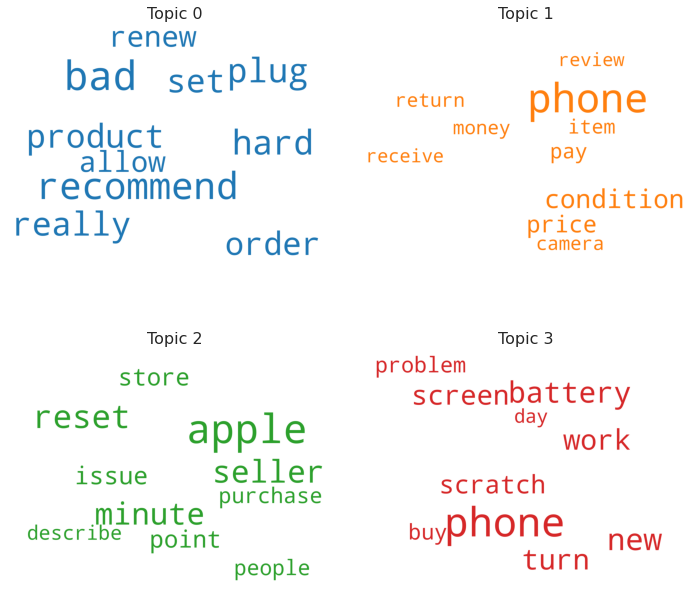

In [46]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

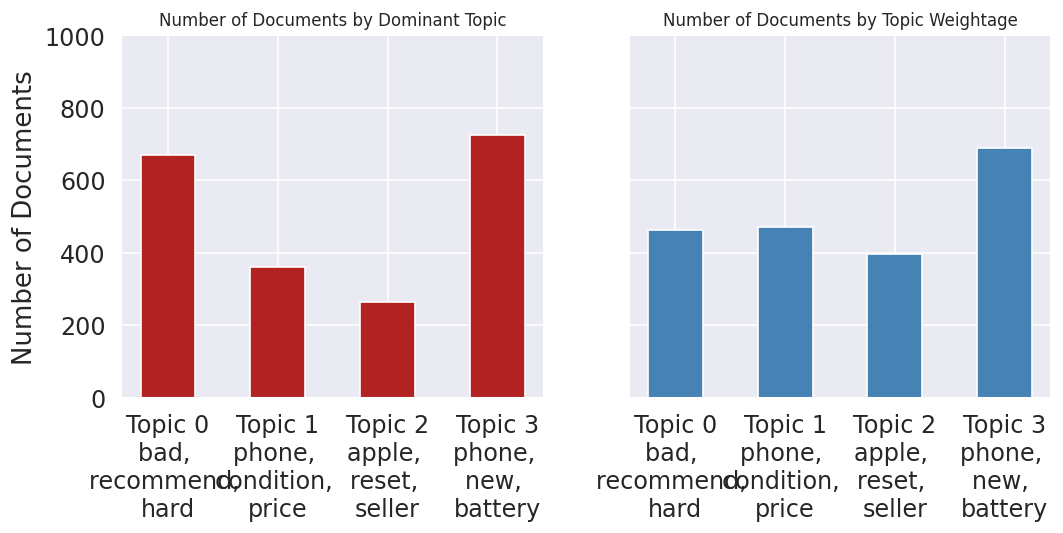

In [48]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [49]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.243783 -0.033885       1        1  37.966423
0      0.197540 -0.251961       2        1  24.623816
1     -0.138654  0.035049       3        1  22.694826
2      0.184896  0.250797       4        1  14.714940, topic_info=            Term         Freq        Total Category  logprob  loglift
183        phone  1266.000000  1266.000000  Default  30.0000  30.0000
2          apple   216.000000   216.000000  Default  29.0000  29.0000
71           new   359.000000   359.000000  Default  28.0000  28.0000
52       battery   334.000000   334.000000  Default  27.0000  27.0000
122         turn   313.000000   313.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
387        check    24.680775    36.654545   Topic4  -4.7259   1.5208
807       broken    15.771140    21.127695   Topic4  -5.1738   1.6239
1083       short    15.502012    21.194065   Topic4  -5.1910   1.6036
548   microphone    15.301903    21.256594   Topic4  -5.2040   1.5876
661      respond    16.111137    28.691299   Topic4  -5.1524   1.3392

[173 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1356      1  0.043372  accessory
1356      2  0.043372  accessory
1356      4  0.867443  accessory
147       3  0.979649  advertise
554       1  0.073933      allow
...     ...       ...        ...
328       3  0.984004       wait
36        4  0.955690   warranty
138       3  0.973246      waste
146       3  0.989424       well
123       1  0.997807       work

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

# Ratings Prediction from reviews

In [0]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [0]:
merged_data['Customer_Rating']=merged_data['Customer_Rating'].astype(str)
texts = [merged_data['body'] for review in reviews]
stars = [merged_data['Customer_Rating'] for review in reviews]
from collections import Counter

def balance_classes(xs, ys):

  freqs = Counter(ys)

# the least common class is the maximum number we want for all classes
  max_allowable = freqs.most_common()[-1][1]
  num_added = {clss: 0 for clss in freqs.keys()}
  new_ys = []
  new_xs = []
  for i, y in enumerate(ys):
    if num_added[y] < max_allowable:
      new_ys.append(y)
      new_xs.append(xs[i])
      num_added[y] += 1

  return new_xs, new_ys

print(Counter(merged_data['Customer_Rating']))
balanced_x, balanced_y = balance_classes(merged_data['body'], merged_data['Customer_Rating'])
print(Counter(balanced_y))
#print(Counter(balanced_x))

tfidf_vectorizer=TfidfVectorizer(ngram_range=(1,2))
vectors = tfidf_vectorizer.fit_transform(balanced_x)


X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.33, random_state=42)


from sklearn.svm import LinearSVC
svmclassifier = LinearSVC()
svmclassifier.fit(X_train, y_train)


preds = svmclassifier.predict(X_test)
print(list(preds[:10]))
print(y_test[:10])

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, preds))

In [0]:
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', LogisticRegression(solver='newton-cg', multi_class='multinomial'))])
X = apple['clean_text']
y = apple['Customer_Rating']
review_trainLR, review_testLR, label_trainLR, label_testLR = train_test_split(X, y, test_size=0.3, random_state=101)
pipeline.fit(review_trainLR, label_trainLR)
pipe_predictedLR = pipeline.predict(review_testLR)
print(metrics.classification_report(label_testLR,pipe_predictedLR))
scores_LR = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5,scoring=('r2', 'neg_mean_squared_error'))
#print(scores_LR['test_score'].mean())
print(scores_LR['test_r2'].mean())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.52      0.30      0.38       357
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00       176
           5       0.60      0.95      0.73       849

    accuracy                           0.59      1544
   macro avg       0.22      0.25      0.22      1544
weighted avg       0.45      0.59      0.49      1544

-0.4473772842462781


Naive Bayes Model

In [0]:
#Multinomial Naive Bayes 
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', MultinomialNB())
])
X2 = apple['clean_text']
y2 = apple['Customer_Rating']
review_train2, review_test2, label_train2, label_test2 = train_test_split(X2, y2, test_size=0.3)
pipeline.fit(review_train2, label_train2)
pip_pred2 = pipeline.predict(review_test2)
print(metrics.classification_report(label_test2, pip_pred2))
scores_NB = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5)
print(scores_NB['test_score'].mean())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      0.01      0.01       335
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        99
           4       0.00      0.00      0.00       158
           5       0.57      1.00      0.73       882

    accuracy                           0.57      1544
   macro avg       0.31      0.20      0.15      1544
weighted avg       0.54      0.57      0.42      1544

0.5533527696793004


Random Forest model

In [0]:
# RandomForest
pipeline = Pipeline([
    ('Tf-Idf', TfidfVectorizer(ngram_range=(1,2), analyzer=clean_text)),
    ('classifier', RandomForestClassifier())])
X3 = apple['clean_text']
y3 = apple['Customer_Rating']
review_trainRF, review_testRF, label_trainRF, label_testRF = train_test_split(X3, y3, test_size=0.3)
pipeline.fit(review_trainRF, label_trainRF)
pipeline_predictedRF= pipeline.predict(review_testRF)
print(metrics.classification_report(label_testRF, pipeline_predictedRF))
scores_RF = cross_validate(pipeline, apple['clean_text'], apple['Customer_Rating'], cv=5)
print(scores_RF['test_score'].mean())

              precision    recall  f1-score   support

           1       0.67      0.41      0.51       356
           2       1.00      0.12      0.22        80
           3       1.00      0.16      0.28        94
           4       0.77      0.15      0.25       154
           5       0.65      0.96      0.78       860

    accuracy                           0.66      1544
   macro avg       0.82      0.36      0.41      1544
weighted avg       0.71      0.66      0.60      1544

0.5968901846452866
